#Outlier Detection with Autoencoder Ensembles










##Importing libraries





In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    cohen_kappa_score,
    roc_auc_score,
    roc_curve,
)

##Data editing

In [ ]:
from google.colab import files
upload = files.upload()

Saving CTG.xls to CTG.xls


In [ ]:
df = pd.read_excel('CTG.xls', sheet_name='Data')
df, df.columns = df[1:] , df.iloc[0] # delete first row, new header

df = df.iloc[:, 10:]
df.drop(df.iloc[:, 21:35], axis=1, inplace=True)

df.drop(df.tail(3).index, inplace=True)  #delete last 3 rows --> NaN values
print(df)

0      LB        AC        FM        UC        DL DS DP ASTV MSTV ALTV  ...  \
1     120         0         0         0         0  0  0   73  0.5   43  ...   
2     132   0.00638         0   0.00638   0.00319  0  0   17  2.1    0  ...   
3     133  0.003322         0  0.008306  0.003322  0  0   16  2.1    0  ...   
4     134  0.002561         0  0.007682  0.002561  0  0   16  2.4    0  ...   
5     132  0.006515         0  0.008143         0  0  0   16  2.4    0  ...   
...   ...       ...       ...       ...       ... .. ..  ...  ...  ...  ...   
2122  140         0         0  0.007426         0  0  0   79  0.2   25  ...   
2123  140  0.000775         0  0.006971         0  0  0   78  0.4   22  ...   
2124  140   0.00098         0  0.006863         0  0  0   79  0.4   20  ...   
2125  140  0.000679         0   0.00611         0  0  0   78  0.4   27  ...   
2126  142  0.001616  0.001616  0.008078         0  0  0   74  0.4   36  ...   

0     Min  Max Nmax Nzeros Mode Mean Median Varianc

In [ ]:
df['NSP'].isnull().values.any() # check if column NSP contains null values

False

##Class distribution

Text(0, 0.5, 'Frequency')

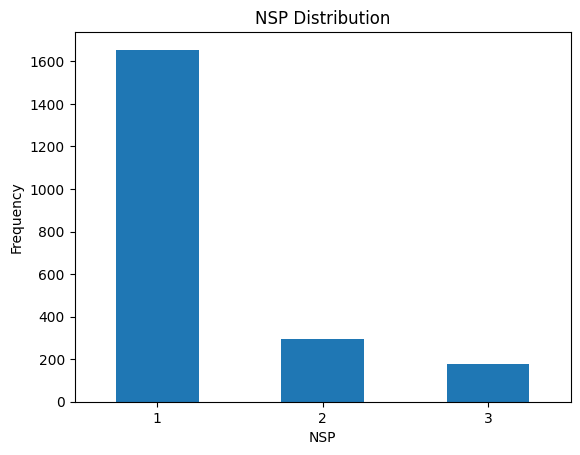

In [ ]:
count_classes = pd.value_counts(df['NSP'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("NSP Distribution")
plt.xlabel("NSP")
plt.ylabel("Frequency")

In [ ]:
df = df.drop(df[df['NSP']==2].index) # drop NSP where class is equal to 2, not our interest


pd.value_counts(df['NSP'])

df['NSP'] = df['NSP'].replace([1], 1)
df['NSP'] = df['NSP'].replace([3], 0)

print(df)

pd.value_counts(df['NSP'])


0      LB        AC        FM        UC        DL DS        DP ASTV MSTV ALTV  \
2     132   0.00638         0   0.00638   0.00319  0         0   17  2.1    0   
3     133  0.003322         0  0.008306  0.003322  0         0   16  2.1    0   
4     134  0.002561         0  0.007682  0.002561  0         0   16  2.4    0   
5     132  0.006515         0  0.008143         0  0         0   16  2.4    0   
6     134  0.001049         0  0.010493  0.009444  0  0.002099   26  5.9    0   
...   ...       ...       ...       ...       ... ..       ...  ...  ...  ...   
2118  140         0         0  0.007812         0  0         0   79  0.3   20   
2119  140         0         0   0.00647  0.000924  0         0   79  0.5   26   
2120  140         0         0  0.006764  0.001127  0         0   79  0.6   27   
2121  140         0         0  0.004975  0.001244  0         0   77  0.7   17   
2126  142  0.001616  0.001616  0.008078         0  0         0   74  0.4   36   

0     ...  Min  Max Nmax Nz

1    1655
0     176
Name: NSP, dtype: int64

##Data visualisation

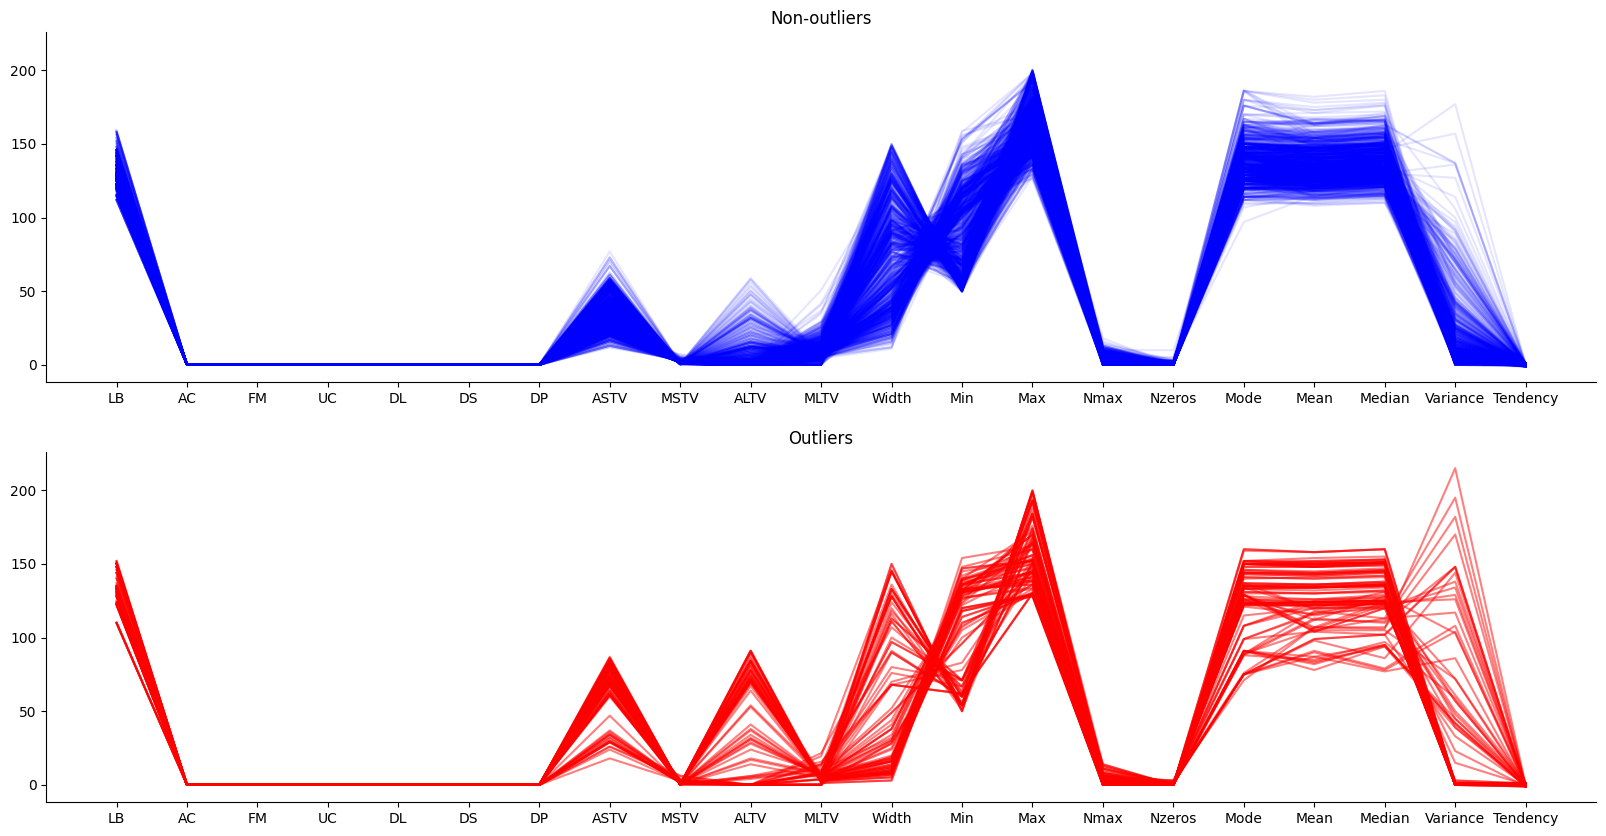

In [ ]:
feature_cols = df.columns[:-1]

inlier_data = df[df.NSP == 1].reset_index()
outlier_data = df[df.NSP == 0].reset_index()

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=True)
axs[0].plot(inlier_data.loc[:1000, feature_cols].T, c="blue", alpha=0.1)
axs[0].set_title("Non-outliers")
axs[1].plot(outlier_data.loc[:100, feature_cols].T, c="red", alpha=0.5)
axs[1].set_title("Outliers")
sns.despine()
plt.show()

In [ ]:
plot_data = df.melt(value_vars=feature_cols,
                    id_vars=["NSP"],
                    var_name='groups',
                    value_name='vals')

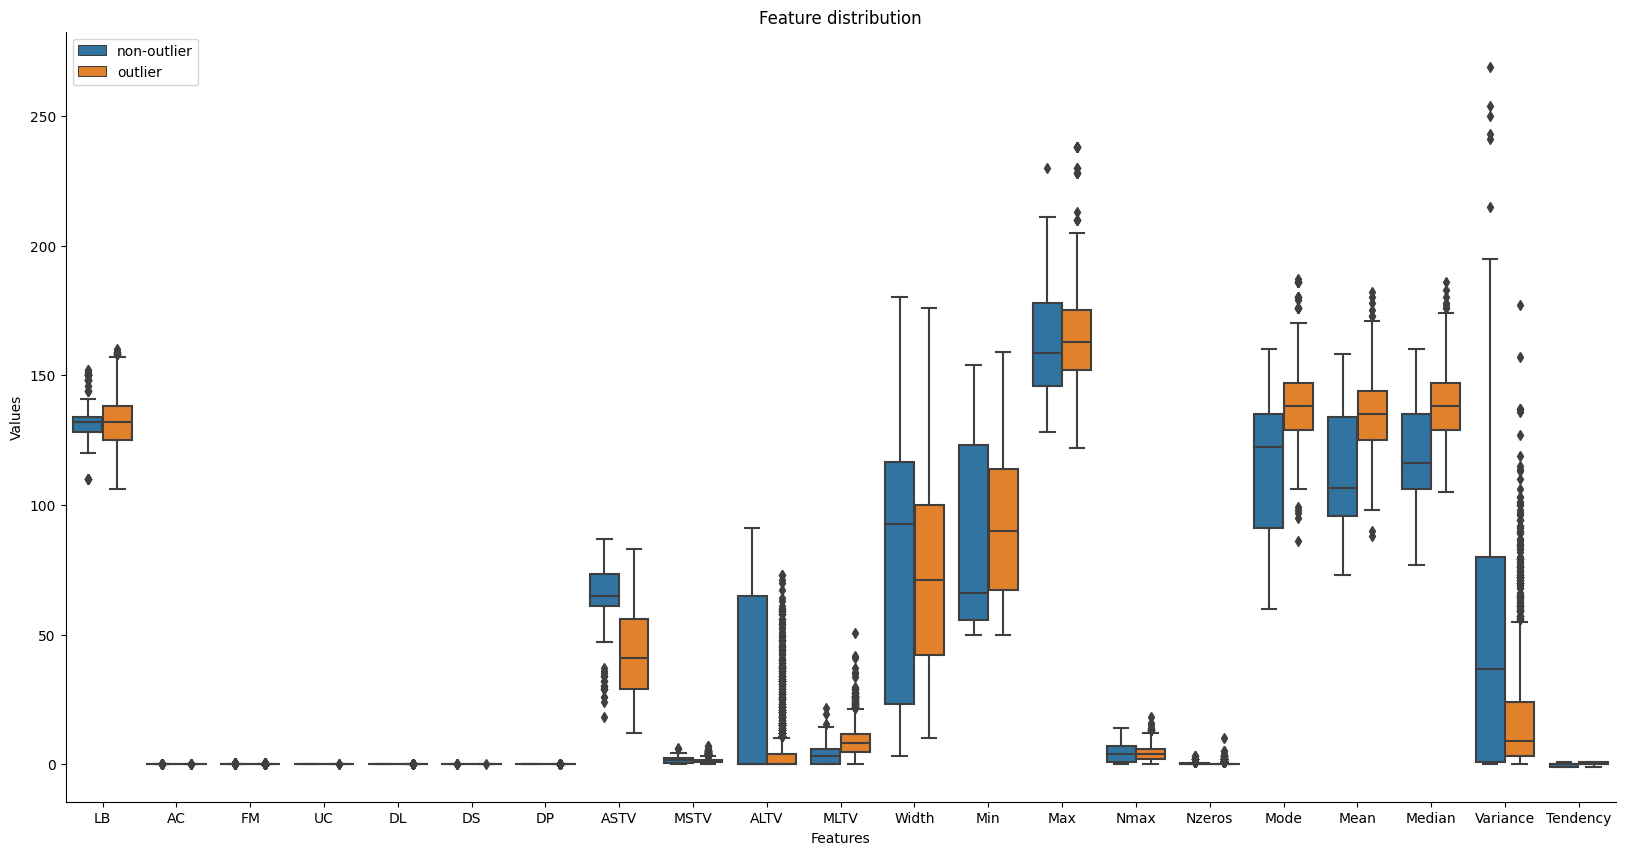

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="groups", y="vals", hue="NSP", data=plot_data, ax=axs)
sns.despine()
plt.xlabel("Features")
plt.ylabel("Values")
L=plt.legend()
L.get_texts()[0].set_text('non-outlier')
L.get_texts()[1].set_text('outlier')
plt.title("Feature distribution")
plt.show()

#Data spliting

In [ ]:
# Just values, without column name
raw_data = df.values

# Values of NSP columns (0,1)
labels = raw_data[:, -1]

# All other values
data = raw_data[:, 0:-1]

X_train, X_rem, y_train, y_rem = train_test_split(data, labels, train_size=0.8, random_state = 21)

# Now since we want the valid and test size to be equal (10% each of overall data).
# We have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state = 21)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)


(1464, 21)
(1464,)
(183, 21)
(183,)
(184, 21)
(184,)


(None, None)

#Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
#normTest = MinMaxScaler().fit(X_test)

# transform training data
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)
X_valid = norm.transform(X_valid)

train_labels = y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]

##Normal data plot

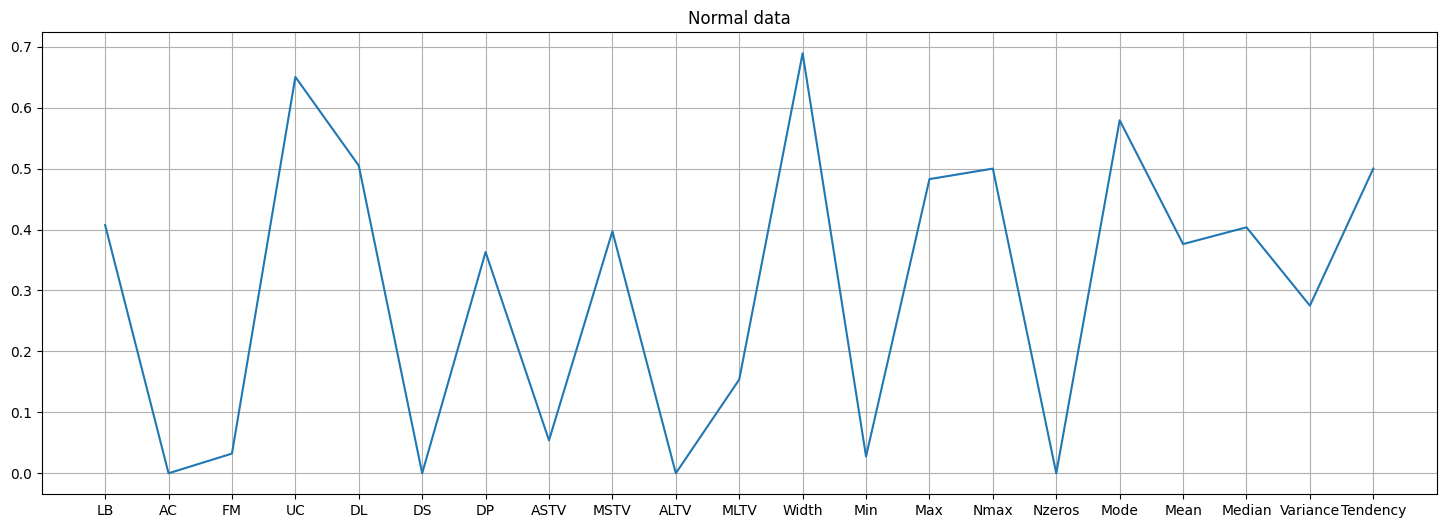

In [ ]:
plt.figure(figsize=(18, 6))
plt.grid()
feature_cols = df.columns[:-1]
plt.plot(feature_cols, normal_train_data[0])
plt.title("Normal data")
plt.show()

##Outlier data plot

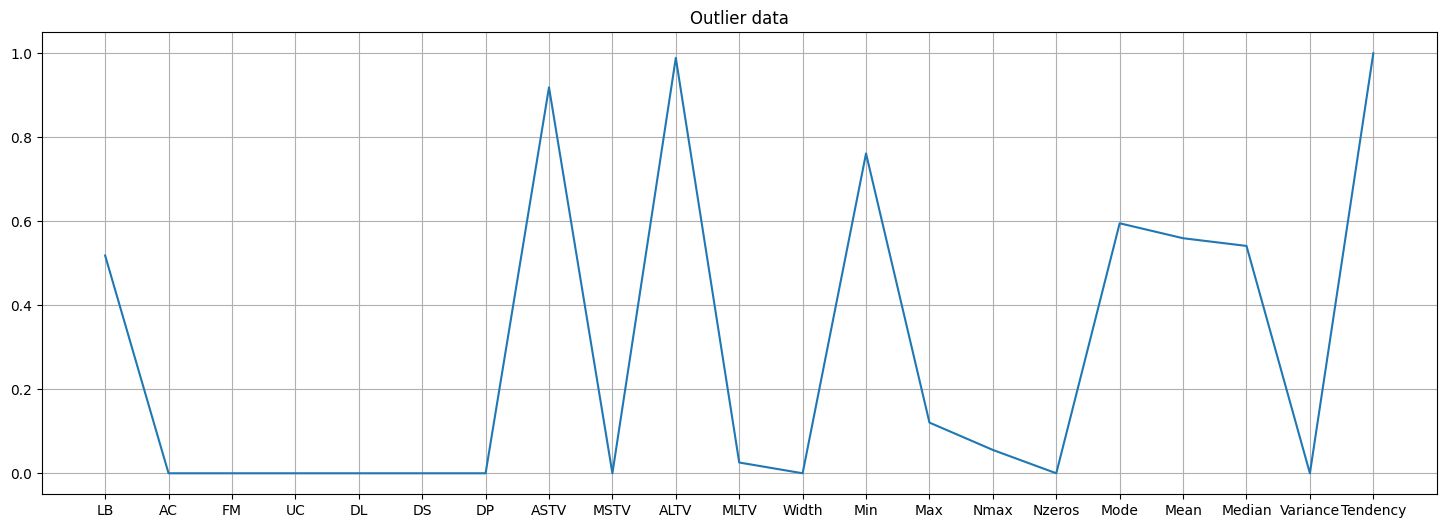

In [ ]:
plt.figure(figsize=(18, 6))
plt.grid()
feature_cols = df.columns[:-1]
plt.plot(feature_cols, anomalous_train_data[0])
plt.title("Outlier data")
plt.show()

#Creating Model

In [ ]:
class RandAE(tf.keras.Sequential):
    def __init__(self, input_dim, hidden_dims, drop_ratio=0.5, **kwargs):
        super(RandAE, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.drop_ratio = drop_ratio

        self.layer_masks = dict()

        self.build_model()

    def build_model(self) -> None:
        """
        Adds the layers and records masks.
        """

        self.add(layers.Input(self.input_dim, name="input"))

        for i, dim in enumerate(self.hidden_dims):
            layer_name = f"hidden_{i}"
            layer = layers.Dense(dim,
                                 activation="relu" if i > 0 else "sigmoid",
                                 name=layer_name)
            self.add(layer)

            # add layer mask
            self.layer_masks[layer_name] = self.get_mask(layer)

        layer_name = "output"
        output_layer = layers.Dense(self.input_dim, activation="sigmoid", name=layer_name)
        self.add(output_layer)
        self.layer_masks[layer_name] = self.get_mask(output_layer)

    def get_mask(self, layer) -> np.ndarray:
        """
        Build mask for a layer.
        """

        shape = layer.input_shape[1], layer.output_shape[1]

        return np.random.choice([0., 1.], size=shape, p=[self.drop_ratio, 1-self.drop_ratio])

    def load_masks(self, mask_pickle_path) -> None:
        """
        Load the masks from a pickled dictionary.
        """

        with open(mask_pickle_path, 'rb') as handle:
            self.layer_masks = pickle.load(handle)

    def get_encoder(self) -> keras.Sequential:
        """
        Get the encoder from the full model.
        """

        n_layers = (len(self.hidden_dims)+1)//2
        encoder_layers = [layers.Input(self.input_dim)] + self.layers[:n_layers]

        return keras.Sequential(encoder_layers)


    def mask_weights(self) -> None:
        """
        Apply the masks to each layer in the encoder and decoder.
        """

        for layer in self.layers:
            layer_name = layer.name
            if layer_name in self.layer_masks:
                masked_w = layer.weights[0].numpy()*self.layer_masks[layer_name]
                b = layer.weights[1].numpy()
                layer.set_weights((masked_w, b))

    def call(self, data, training=True) -> tf.Tensor:

        # mask the weights before original forward pass
        self.mask_weights()

        return super().call(data)

#Model training

In [ ]:
single_model = RandAE(X_train.shape[1], [18, 14, 10, 6, 10, 14, 18], drop_ratio=0)
single_model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), loss="mse", run_eagerly=True, metrics=["mse"])
single_model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)

print(f"Baseline loss: {np.square(X_train - X_train.mean(axis=0)).mean()}")
history = single_model.fit(normal_train_data, normal_train_data, epochs=100, batch_size=32, shuffle = True, validation_data = (X_valid, X_valid), callbacks=[early_stop])

Model: "rand_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 18)                396       
                                                                 
 hidden_1 (Dense)            (None, 14)                266       
                                                                 
 hidden_2 (Dense)            (None, 10)                150       
                                                                 
 hidden_3 (Dense)            (None, 6)                 66        
                                                                 
 hidden_4 (Dense)            (None, 10)                70        
                                                                 
 hidden_5 (Dense)            (None, 14)                154       
                                                                 
 hidden_6 (Dense)            (None, 18)                270 

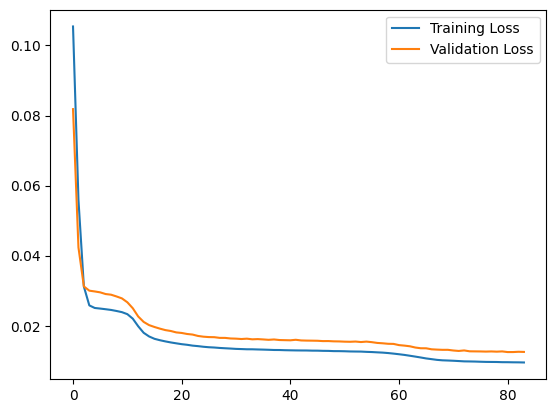

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

#Latent representation

In [ ]:
encoder = single_model.get_encoder()

vis_data_latent = encoder.predict(X_valid)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(vis_data_latent)

6/6 [==============================] - 0s 2ms/step


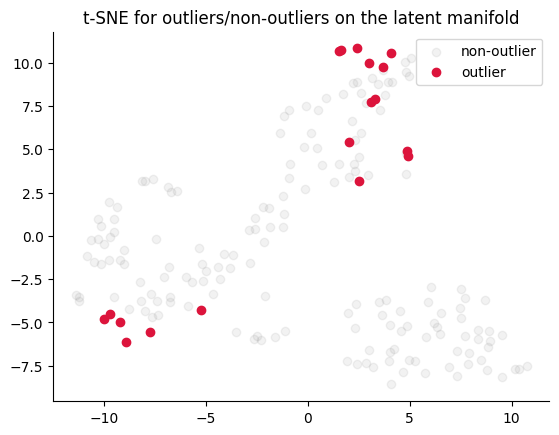

In [ ]:
plt.figure()
plt.scatter(tsne_data[y_valid == 1, 0],
            tsne_data[y_valid == 1, 1], c="grey", alpha=0.1, label="non-outlier")
plt.scatter(tsne_data[y_valid == 0, 0],
            tsne_data[y_valid == 0, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/non-outliers on the latent manifold")
plt.show()

##Model prediction



42/42 [==============================] - 1s 15ms/step


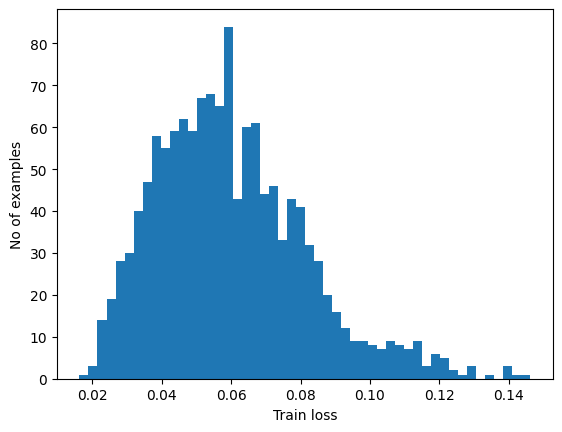

In [ ]:
reconstructions = single_model.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

###Choose threshold

###Training threshold

In [ ]:
threshold = np.mean(train_loss) + 1.5 * np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.09250611871300968


###Validation threshold

6/6 [==============================] - 0s 40ms/step
Threshold:  0.10209986540167462


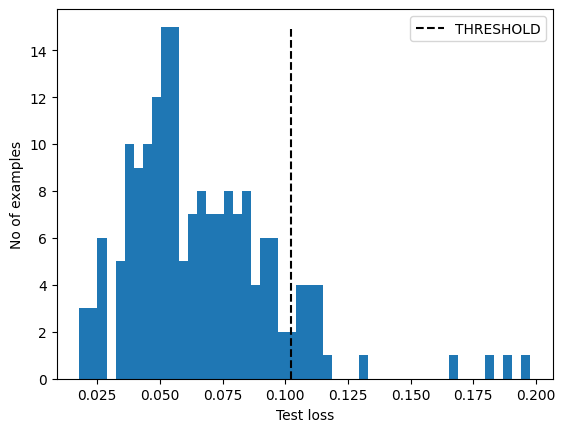

In [ ]:
reconstructions = single_model.predict(X_valid)
valid_loss = tf.keras.losses.mae(reconstructions, X_valid)

threshold = np.mean(valid_loss) + 1.2 * np.std(valid_loss)
print("Threshold: ", threshold)

plt.hist(valid_loss[None, :], bins=50)
plt.vlines(threshold, ymin = 0, ymax = 15, linestyles="--", colors="black")
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.legend(["THRESHOLD"])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds, loss = predict(single_model, X_test, threshold)
print_stats(preds, test_labels)

cr = classification_report(test_labels, preds)
print(cr)

Accuracy = 0.9347826086956522
Precision = 0.9625
Recall = 0.9625
              precision    recall  f1-score   support

       False       0.75      0.75      0.75        24
        True       0.96      0.96      0.96       160

    accuracy                           0.93       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.93      0.93      0.93       184



5/5 [==============================] - 0s 49ms/step


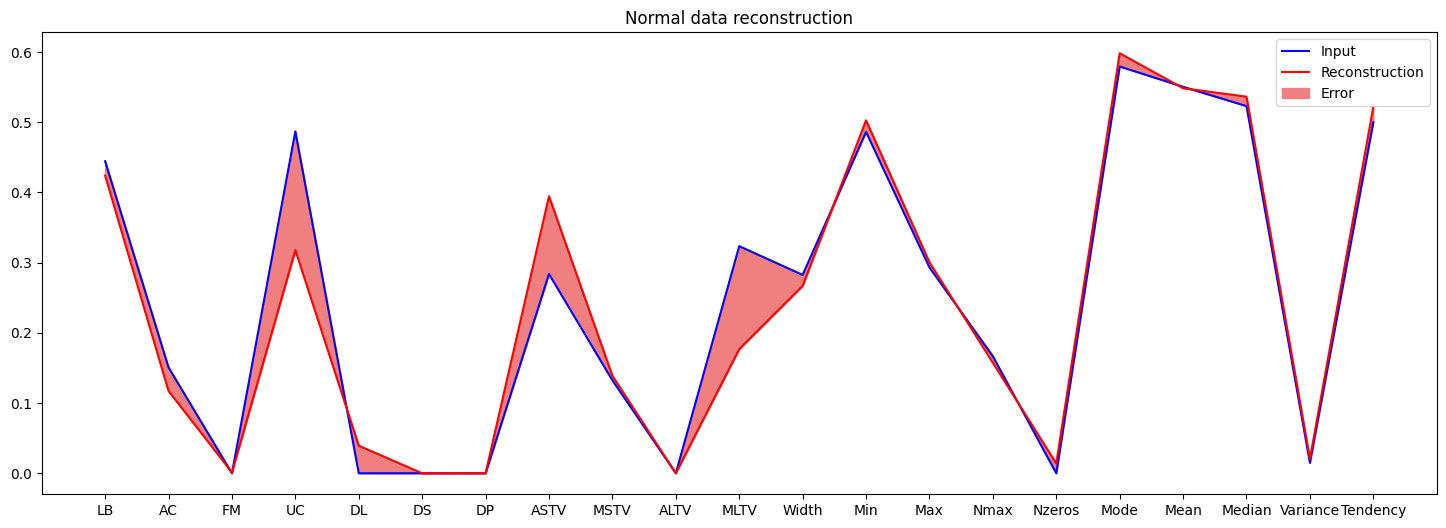

In [ ]:
reconstructions = single_model.predict(normal_test_data)

encoded_data = normal_test_data
decoded_data = reconstructions

plt.figure(figsize=(18, 6))
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(feature_cols, decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Normal data reconstruction")
plt.show()

1/1 [==============================] - 0s 37ms/step


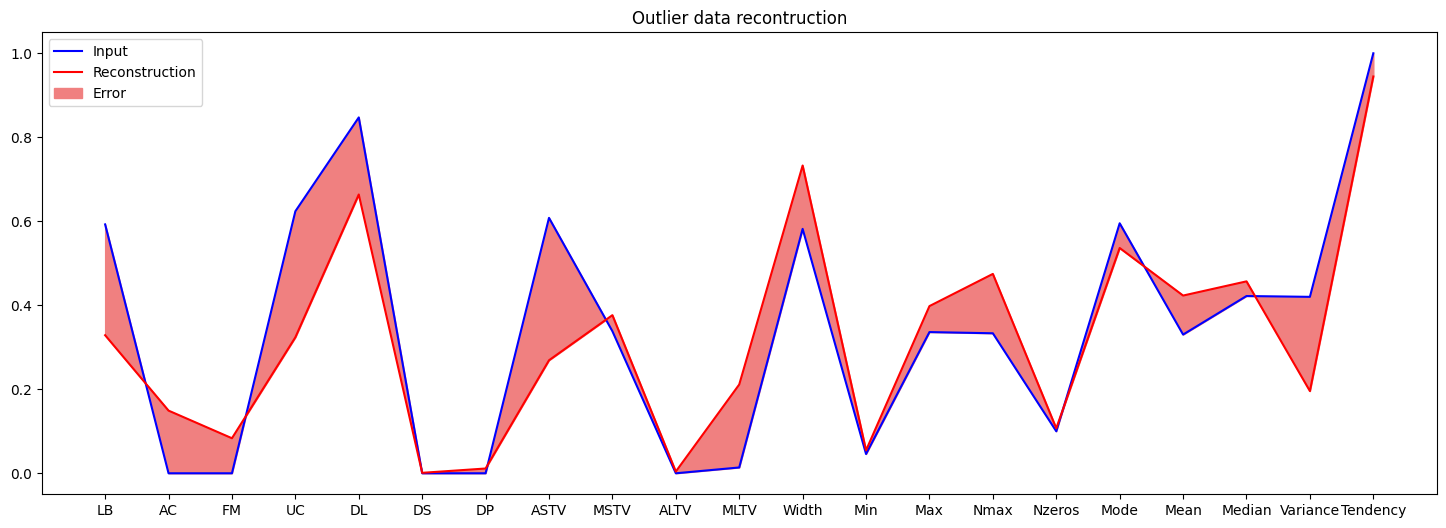

In [ ]:
reconstructions = single_model.predict(anomalous_test_data)

encoded_data = anomalous_test_data
decoded_data = reconstructions

plt.figure(figsize=(18, 6))
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(feature_cols, decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Outlier data recontruction")
plt.show()

#Showing results

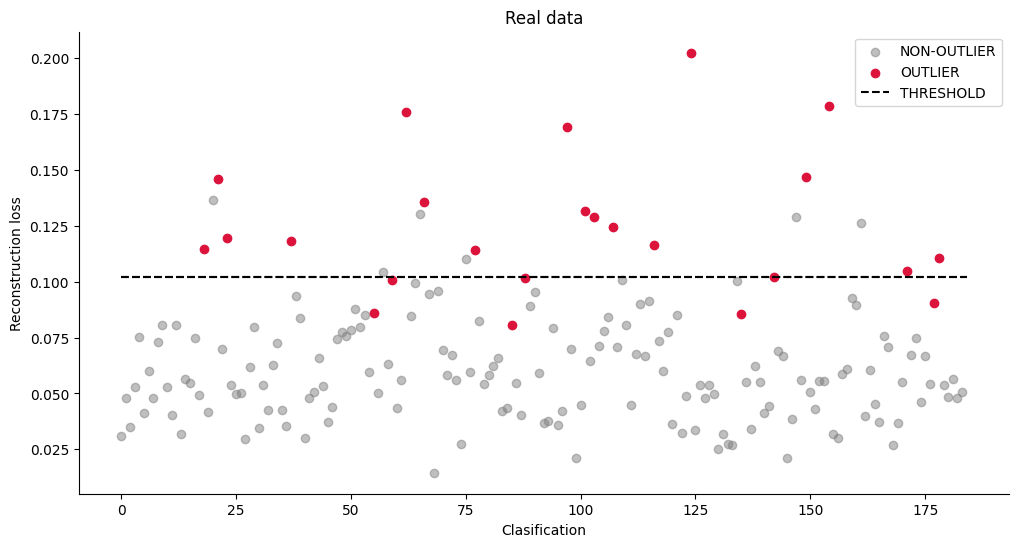

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(np.where(y_test==1)[0],
            loss[(y_test == 1).ravel()],
            c="grey",
            alpha=0.5)
plt.scatter(np.where(y_test == 0)[0],
            loss[(y_test == 0).ravel()],
            c="crimson",
            alpha=1)
plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")


plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")
plt.xlabel("Clasification")
plt.ylabel("Reconstruction loss")
plt.legend(['NON-OUTLIER', "OUTLIER", "THRESHOLD"])
plt.title("Real data")
sns.despine()

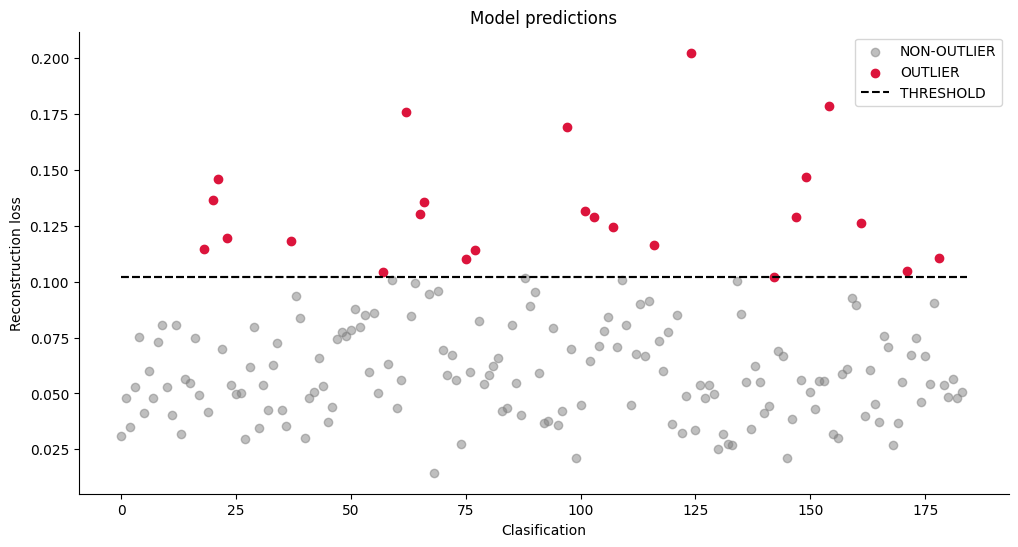

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(np.where(preds==True)[0],
            loss[(preds == True)],
            c="grey",
            alpha=0.5)
plt.scatter(np.where(preds == False)[0],
            loss[(preds == False)],
            c="crimson",
            alpha=1)
plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")


plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")
plt.xlabel("Clasification")
plt.ylabel("Reconstruction loss")
plt.legend(['NON-OUTLIER', "OUTLIER", "THRESHOLD"])
plt.title("Model predictions")
sns.despine()

##ROC curve

In [ ]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    auc = roc_auc_score(true_y, y_prob)
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

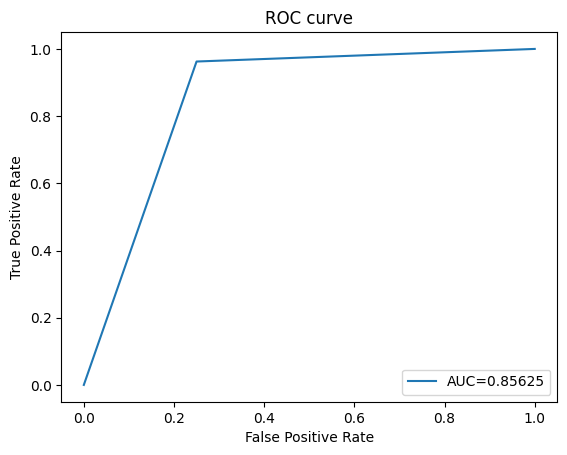

In [ ]:
plot_roc_curve(y_test.astype(bool), preds)

#AUTOENCODER ENSEMBLE

##Ensemble training

In [ ]:
MODEL_PARAMS ={"input_dim": X_train.shape[1],
               "hidden_dims": [18, 14, 10, 6, 10, 14, 18],
               "drop_ratio": 0.33}

COMPILE_PARAMS = {"optimizer": tf.optimizers.legacy.Adam(learning_rate=0.001),
                 "loss": keras.losses.MeanSquaredError(),
                 "run_eagerly": True,
                  }

EPOCHS = 100

n_models = 50
ensemble = []

from tqdm import tqdm
import pickle

for i in tqdm(range(n_models)):
    model = RandAE(**MODEL_PARAMS)
    model.compile(**COMPILE_PARAMS)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)

    history = model.fit(normal_train_data, normal_train_data, epochs=EPOCHS, batch_size=32, shuffle = True, validation_data = (X_valid, X_valid), callbacks=[early_stop])

    ensemble.append(model)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/100
42/42 [==============================] - 3s 70ms/step - loss: 0.1145 - val_loss: 0.1095
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0972 - val_loss: 0.0848
Epoch 3/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0668 - val_loss: 0.0589
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0458 - val_loss: 0.0426
Epoch 5/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0331 - val_loss: 0.0339
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0279 - val_loss: 0.0314
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0264 - val_loss: 0.0307
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0259 - val_loss: 0.0306
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0256 - val_loss: 0.0304
Epoch 10/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0254 - val_loss: 0.0301

  2%|▏         | 1/50 [03:13<2:38:20, 193.90s/it]

Epoch 1/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0686 - val_loss: 0.0340
Epoch 2/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0265 - val_loss: 0.0301
Epoch 3/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0248 - val_loss: 0.0291
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0245 - val_loss: 0.0288
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0243 - val_loss: 0.0285
Epoch 8/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0239 - val_loss: 0.0281
Epoch 9/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0236 - val_loss: 0.0277
Epoch 10/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0233 - val_loss: 0.0272

  4%|▍         | 2/50 [05:39<2:12:36, 165.76s/it]

Epoch 1/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0725 - val_loss: 0.0370
Epoch 2/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0281 - val_loss: 0.0310
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0258 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0245 - val_loss: 0.0283
Epoch 7/100
42/42 [==============================] - 4s 91ms/step - loss: 0.0231 - val_loss: 0.0263
Epoch 8/100
42/42 [==============================] - 3s 76ms/step - loss: 0.0214 - val_loss: 0.0247
Epoch 9/100
42/42 [==============================] - 3s 67ms/step - loss: 0.0199 - val_loss: 0.0237
Epoch 10/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0190 - val_loss: 0.0230

  6%|▌         | 3/50 [10:05<2:45:37, 211.43s/it]

Epoch 1/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0584 - val_loss: 0.0316
Epoch 2/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0258 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0254 - val_loss: 0.0301
Epoch 4/100
42/42 [==============================] - 2s 39ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0250 - val_loss: 0.0295
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0247 - val_loss: 0.0292
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0240 - val_loss: 0.0281
Epoch 8/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0225 - val_loss: 0.0261
Epoch 9/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0204 - val_loss: 0.0241
Epoch 10/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0187 - val_loss: 0.0230

  8%|▊         | 4/50 [13:35<2:41:41, 210.89s/it]

Epoch 1/100
42/42 [==============================] - 6s 139ms/step - loss: 0.0689 - val_loss: 0.0318
Epoch 2/100
42/42 [==============================] - 4s 88ms/step - loss: 0.0261 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0255 - val_loss: 0.0304
Epoch 4/100
42/42 [==============================] - 4s 102ms/step - loss: 0.0253 - val_loss: 0.0303
Epoch 5/100
42/42 [==============================] - 4s 100ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 3s 82ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 39ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 9/100
42/42 [==============================] - 2s 48ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 10/100
42/42 [==============================] - 2s 39ms/step - loss: 0.0247 - val_loss: 0.0

 10%|█         | 5/50 [17:57<2:52:01, 229.36s/it]

Epoch 1/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0698 - val_loss: 0.0357
Epoch 2/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0271 - val_loss: 0.0308
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0255 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0298
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0298
Epoch 7/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0248 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 60ms/step - loss: 0.0247 - val_loss: 0.0292
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0244 - val_loss: 0.0289
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0242 - val_loss: 0.0285

 12%|█▏        | 6/50 [19:57<2:20:55, 192.18s/it]

Epoch 1/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0748 - val_loss: 0.0344
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0265 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0254 - val_loss: 0.0304
Epoch 4/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 6/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0248 - val_loss: 0.0295
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0246 - val_loss: 0.0289
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0239 - val_loss: 0.0274
Epoch 10/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0224 - val_loss: 0.0254

 14%|█▍        | 7/50 [22:35<2:09:43, 181.01s/it]

Epoch 1/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0712 - val_loss: 0.0347
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0264 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 4/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0248 - val_loss: 0.0294
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 8/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0243 - val_loss: 0.0285
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 10/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0234 - val_loss: 0.0271

 16%|█▌        | 8/50 [25:04<1:59:29, 170.71s/it]

Epoch 1/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0546 - val_loss: 0.0312
Epoch 2/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0257 - val_loss: 0.0303
Epoch 3/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0251 - val_loss: 0.0300
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0248 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 9/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0244 - val_loss: 0.0288
Epoch 10/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0241 - val_loss: 0.0284

 18%|█▊        | 9/50 [26:35<1:39:40, 145.87s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.1053 - val_loss: 0.0942
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0847 - val_loss: 0.0806
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0735 - val_loss: 0.0722
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0662 - val_loss: 0.0662
Epoch 5/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0607 - val_loss: 0.0616
Epoch 6/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0565 - val_loss: 0.0580
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0531 - val_loss: 0.0550
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0503 - val_loss: 0.0526
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0480 - val_loss: 0.0505
Epoch 10/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0460 - val_loss: 0.0487

 20%|██        | 10/50 [30:48<1:59:16, 178.92s/it]

Epoch 1/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0707 - val_loss: 0.0348
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0269 - val_loss: 0.0307
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 6/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0247 - val_loss: 0.0294
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0245 - val_loss: 0.0291

 22%|██▏       | 11/50 [34:10<2:00:54, 186.01s/it]

Epoch 1/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0912 - val_loss: 0.0509
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0262 - val_loss: 0.0305
Epoch 4/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0255 - val_loss: 0.0304
Epoch 5/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0248 - val_loss: 0.0294
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0246 - val_loss: 0.0292
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0243 - val_loss: 0.0285
Epoch 10/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0238 - val_loss: 0.0281

 24%|██▍       | 12/50 [37:32<2:00:54, 190.90s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0682 - val_loss: 0.0329
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0265 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0254 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0298
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0244 - val_loss: 0.0288
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0240 - val_loss: 0.0284

 26%|██▌       | 13/50 [40:55<1:59:48, 194.29s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0799 - val_loss: 0.0352
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0269 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 5/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0248 - val_loss: 0.0292
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0242 - val_loss: 0.0284
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0234 - val_loss: 0.0277
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0226 - val_loss: 0.0266
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0212 - val_loss: 0.0252
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0199 - val_loss: 0.0242

 28%|██▊       | 14/50 [43:24<1:48:24, 180.68s/it]

Epoch 1/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0714 - val_loss: 0.0339
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0266 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0249 - val_loss: 0.0294
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0244 - val_loss: 0.0280
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0226 - val_loss: 0.0248
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0199 - val_loss: 0.0221
Epoch 10/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0184 - val_loss: 0.0214

 30%|███       | 15/50 [46:33<1:46:49, 183.13s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0644 - val_loss: 0.0330
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0262 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 5/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0248 - val_loss: 0.0295
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0247 - val_loss: 0.0291
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0244 - val_loss: 0.0290
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0242 - val_loss: 0.0285
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0238 - val_loss: 0.0279

 32%|███▏      | 16/50 [47:52<1:26:03, 151.87s/it]

Epoch 1/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0707 - val_loss: 0.0338
Epoch 2/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0262 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 3s 63ms/step - loss: 0.0253 - val_loss: 0.0303
Epoch 5/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0298
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 8/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0247 - val_loss: 0.0294
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0244 - val_loss: 0.0287
Epoch 10/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0239 - val_loss: 0.0279

 34%|███▍      | 17/50 [49:49<1:17:43, 141.31s/it]

Epoch 1/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0678 - val_loss: 0.0340
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0263 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 4/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0250 - val_loss: 0.0295
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0247 - val_loss: 0.0292
Epoch 6/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0243 - val_loss: 0.0286
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0238 - val_loss: 0.0277
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0228 - val_loss: 0.0263
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0212 - val_loss: 0.0245
Epoch 10/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0197 - val_loss: 0.0234

 36%|███▌      | 18/50 [52:40<1:20:07, 150.24s/it]

Epoch 1/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0788 - val_loss: 0.0421
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0289 - val_loss: 0.0309
Epoch 3/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0255 - val_loss: 0.0304
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 6/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0242 - val_loss: 0.0284
Epoch 8/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0236 - val_loss: 0.0273
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0228 - val_loss: 0.0264
Epoch 10/100
42/42 [==============================] - 2s 58ms/step - loss: 0.0219 - val_loss: 0.0253

 38%|███▊      | 19/50 [54:59<1:15:59, 147.09s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0737 - val_loss: 0.0330
Epoch 2/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0262 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0251 - val_loss: 0.0300
Epoch 5/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0249 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 7/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0245 - val_loss: 0.0288
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0241 - val_loss: 0.0282
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0237 - val_loss: 0.0277
Epoch 10/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0230 - val_loss: 0.0266

 40%|████      | 20/50 [55:53<59:34, 119.16s/it]  

Epoch 1/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0697 - val_loss: 0.0375
Epoch 2/100
42/42 [==============================] - 3s 64ms/step - loss: 0.0286 - val_loss: 0.0311
Epoch 3/100
42/42 [==============================] - 5s 121ms/step - loss: 0.0257 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0254 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0251 - val_loss: 0.0296
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0248 - val_loss: 0.0291
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0245 - val_loss: 0.0289
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 10/100
42/42 [==============================] - 2s 57ms/step - loss: 0.0235 - val_loss: 0.027

 42%|████▏     | 21/50 [59:11<1:08:54, 142.58s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0772 - val_loss: 0.0335
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0263 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0256 - val_loss: 0.0307
Epoch 4/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 7/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0249 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0244 - val_loss: 0.0290
Epoch 10/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0240 - val_loss: 0.0281

 44%|████▍     | 22/50 [1:02:21<1:13:12, 156.86s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0712 - val_loss: 0.0352
Epoch 2/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0265 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 4/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 5/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0247 - val_loss: 0.0290
Epoch 6/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0244 - val_loss: 0.0286
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0240 - val_loss: 0.0279
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0233 - val_loss: 0.0270
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0227 - val_loss: 0.0263
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0221 - val_loss: 0.0258

 46%|████▌     | 23/50 [1:05:31<1:15:06, 166.91s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0641 - val_loss: 0.0325
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0260 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0254 - val_loss: 0.0304
Epoch 4/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 7/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0250 - val_loss: 0.0299
Epoch 8/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0248 - val_loss: 0.0294
Epoch 10/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0247 - val_loss: 0.0293

 48%|████▊     | 24/50 [1:07:55<1:09:18, 159.93s/it]

Epoch 1/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0719 - val_loss: 0.0364
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0277 - val_loss: 0.0309
Epoch 3/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0256 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0247 - val_loss: 0.0291
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0233 - val_loss: 0.0261
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0200 - val_loss: 0.0234
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0184 - val_loss: 0.0223
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0178 - val_loss: 0.0220

 50%|█████     | 25/50 [1:10:50<1:08:32, 164.49s/it]

Epoch 1/100
42/42 [==============================] - 3s 59ms/step - loss: 0.0840 - val_loss: 0.0422
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0288 - val_loss: 0.0309
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0256 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0249 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0248 - val_loss: 0.0295
Epoch 8/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0243 - val_loss: 0.0287
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0240 - val_loss: 0.0283

 52%|█████▏    | 26/50 [1:11:50<53:19, 133.29s/it]  

Epoch 1/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0693 - val_loss: 0.0335
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0262 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 4/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0247 - val_loss: 0.0290
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0243 - val_loss: 0.0283
Epoch 7/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0239 - val_loss: 0.0279
Epoch 8/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0235 - val_loss: 0.0272
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0230 - val_loss: 0.0267
Epoch 10/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0226 - val_loss: 0.0263

 54%|█████▍    | 27/50 [1:14:59<57:24, 149.78s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0799 - val_loss: 0.0391
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0266 - val_loss: 0.0302
Epoch 3/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0252 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0295
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0248 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0245 - val_loss: 0.0288
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0239 - val_loss: 0.0278
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0228 - val_loss: 0.0258

 56%|█████▌    | 28/50 [1:17:18<53:47, 146.68s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0997 - val_loss: 0.0780
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0587 - val_loss: 0.0493
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0393 - val_loss: 0.0391
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0324 - val_loss: 0.0352
Epoch 5/100
42/42 [==============================] - 2s 57ms/step - loss: 0.0296 - val_loss: 0.0334
Epoch 6/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0283 - val_loss: 0.0325
Epoch 7/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0275 - val_loss: 0.0320
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0270 - val_loss: 0.0316
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0267 - val_loss: 0.0313
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0265 - val_loss: 0.0312

 58%|█████▊    | 29/50 [1:18:35<43:57, 125.61s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0690 - val_loss: 0.0325
Epoch 2/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0263 - val_loss: 0.0307
Epoch 3/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0303
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0241 - val_loss: 0.0281
Epoch 9/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0233 - val_loss: 0.0272
Epoch 10/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0224 - val_loss: 0.0259

 60%|██████    | 30/50 [1:21:55<49:20, 148.01s/it]

Epoch 1/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0810 - val_loss: 0.0388
Epoch 2/100
42/42 [==============================] - 3s 59ms/step - loss: 0.0270 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 7/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0243 - val_loss: 0.0287
Epoch 8/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 9/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0231 - val_loss: 0.0271
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0224 - val_loss: 0.0261

 62%|██████▏   | 31/50 [1:24:37<48:14, 152.37s/it]

Epoch 1/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0782 - val_loss: 0.0373
Epoch 2/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0271 - val_loss: 0.0307
Epoch 3/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0256 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0248 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0245 - val_loss: 0.0292
Epoch 9/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0243 - val_loss: 0.0286
Epoch 10/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0239 - val_loss: 0.0280

 64%|██████▍   | 32/50 [1:27:16<46:18, 154.36s/it]

Epoch 1/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0609 - val_loss: 0.0318
Epoch 2/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0256 - val_loss: 0.0302
Epoch 3/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 4/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 5/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0248 - val_loss: 0.0294
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0246 - val_loss: 0.0293
Epoch 7/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0245 - val_loss: 0.0288
Epoch 8/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 9/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0239 - val_loss: 0.0281
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0236 - val_loss: 0.0276

 66%|██████▌   | 33/50 [1:29:52<43:50, 154.74s/it]

Epoch 1/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0625 - val_loss: 0.0306
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0256 - val_loss: 0.0302
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0248 - val_loss: 0.0291
Epoch 6/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0241 - val_loss: 0.0280
Epoch 7/100
42/42 [==============================] - 3s 65ms/step - loss: 0.0231 - val_loss: 0.0267
Epoch 8/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0219 - val_loss: 0.0252
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0203 - val_loss: 0.0238
Epoch 10/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0191 - val_loss: 0.0232

 68%|██████▊   | 34/50 [1:34:01<48:46, 182.93s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0753 - val_loss: 0.0401
Epoch 2/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0280 - val_loss: 0.0305
Epoch 3/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 5/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0246 - val_loss: 0.0292
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0241 - val_loss: 0.0283
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0231 - val_loss: 0.0267
Epoch 9/100
42/42 [==============================] - 4s 102ms/step - loss: 0.0215 - val_loss: 0.0251
Epoch 10/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0201 - val_loss: 0.024

 70%|███████   | 35/50 [1:36:57<45:16, 181.08s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0697 - val_loss: 0.0343
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0263 - val_loss: 0.0301
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0300
Epoch 4/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0250 - val_loss: 0.0295
Epoch 5/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 6/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0245 - val_loss: 0.0290
Epoch 7/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0242 - val_loss: 0.0285
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0238 - val_loss: 0.0279
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0234 - val_loss: 0.0273
Epoch 10/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0228 - val_loss: 0.0265

 72%|███████▏  | 36/50 [1:40:38<45:02, 193.01s/it]

Epoch 1/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0783 - val_loss: 0.0407
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0288 - val_loss: 0.0315
Epoch 3/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0259 - val_loss: 0.0305
Epoch 4/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0254 - val_loss: 0.0303
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 9/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0248 - val_loss: 0.0295
Epoch 10/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0246 - val_loss: 0.0291

 74%|███████▍  | 37/50 [1:42:45<37:28, 172.99s/it]

Epoch 1/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0673 - val_loss: 0.0320
Epoch 2/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0263 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0256 - val_loss: 0.0305
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0255 - val_loss: 0.0306
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0254 - val_loss: 0.0301
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0250 - val_loss: 0.0298
Epoch 9/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 10/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0247 - val_loss: 0.0294

 76%|███████▌  | 38/50 [1:46:22<37:17, 186.47s/it]

Epoch 1/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0654 - val_loss: 0.0324
Epoch 2/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0259 - val_loss: 0.0303
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 4/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 5/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0248 - val_loss: 0.0295
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0246 - val_loss: 0.0291
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0242 - val_loss: 0.0284
Epoch 8/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0236 - val_loss: 0.0275
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0227 - val_loss: 0.0264
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0215 - val_loss: 0.0249

 78%|███████▊  | 39/50 [1:49:45<35:02, 191.16s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0978 - val_loss: 0.0724
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0477 - val_loss: 0.0373
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0295 - val_loss: 0.0322
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0268 - val_loss: 0.0312
Epoch 5/100
42/42 [==============================] - 2s 48ms/step - loss: 0.0261 - val_loss: 0.0308
Epoch 6/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0258 - val_loss: 0.0306
Epoch 7/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0257 - val_loss: 0.0305
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0256 - val_loss: 0.0304
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0255 - val_loss: 0.0305
Epoch 10/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0255 - val_loss: 0.0305

 80%|████████  | 40/50 [1:50:05<23:19, 140.00s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0794 - val_loss: 0.0394
Epoch 2/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 3/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0251 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0246 - val_loss: 0.0289
Epoch 8/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0240 - val_loss: 0.0281
Epoch 9/100
42/42 [==============================] - 2s 57ms/step - loss: 0.0234 - val_loss: 0.0271
Epoch 10/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0214 - val_loss: 0.0240

 82%|████████▏ | 41/50 [1:53:12<23:07, 154.16s/it]

Epoch 1/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0791 - val_loss: 0.0426
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0322 - val_loss: 0.0336
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0270 - val_loss: 0.0314
Epoch 4/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0257 - val_loss: 0.0304
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 6/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0251 - val_loss: 0.0297
Epoch 7/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0249 - val_loss: 0.0296
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0246 - val_loss: 0.0290
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0244 - val_loss: 0.0287
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0241 - val_loss: 0.0282

 84%|████████▍ | 42/50 [1:56:34<22:28, 168.54s/it]

Epoch 1/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0765 - val_loss: 0.0443
Epoch 2/100
42/42 [==============================] - 2s 47ms/step - loss: 0.0351 - val_loss: 0.0363
Epoch 3/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0302 - val_loss: 0.0328
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0269 - val_loss: 0.0305
Epoch 5/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0255 - val_loss: 0.0298
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0250 - val_loss: 0.0293
Epoch 7/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0247 - val_loss: 0.0290
Epoch 8/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0244 - val_loss: 0.0285
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0239 - val_loss: 0.0279
Epoch 10/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0234 - val_loss: 0.0273

 86%|████████▌ | 43/50 [1:57:55<16:34, 142.14s/it]

Epoch 1/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0727 - val_loss: 0.0410
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0289 - val_loss: 0.0309
Epoch 3/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0257 - val_loss: 0.0304
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0254 - val_loss: 0.0301
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 6/100
42/42 [==============================] - 2s 59ms/step - loss: 0.0251 - val_loss: 0.0296
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0248 - val_loss: 0.0293
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0245 - val_loss: 0.0290
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0242 - val_loss: 0.0283
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0239 - val_loss: 0.0279

 88%|████████▊ | 44/50 [2:00:34<14:42, 147.07s/it]

Epoch 1/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0689 - val_loss: 0.0343
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0267 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0253 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 6/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 7/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0249 - val_loss: 0.0297
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0248 - val_loss: 0.0294
Epoch 10/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0246 - val_loss: 0.0293

 90%|█████████ | 45/50 [2:04:29<14:28, 173.66s/it]

Epoch 1/100
42/42 [==============================] - 2s 50ms/step - loss: 0.1053 - val_loss: 0.0943
Epoch 2/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0848 - val_loss: 0.0807
Epoch 3/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0736 - val_loss: 0.0722
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0662 - val_loss: 0.0662
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0608 - val_loss: 0.0617
Epoch 6/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0566 - val_loss: 0.0580
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0532 - val_loss: 0.0551
Epoch 8/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0504 - val_loss: 0.0526
Epoch 9/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0480 - val_loss: 0.0505
Epoch 10/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0460 - val_loss: 0.0487

 92%|█████████▏| 46/50 [2:07:51<12:08, 182.19s/it]

Epoch 1/100
42/42 [==============================] - 2s 44ms/step - loss: 0.0694 - val_loss: 0.0351
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0264 - val_loss: 0.0303
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0254 - val_loss: 0.0300
Epoch 4/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0251 - val_loss: 0.0298
Epoch 5/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0250 - val_loss: 0.0293
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0246 - val_loss: 0.0289
Epoch 7/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0242 - val_loss: 0.0281
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0236 - val_loss: 0.0273
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0227 - val_loss: 0.0256
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0213 - val_loss: 0.0241

 94%|█████████▍| 47/50 [2:10:49<09:02, 180.79s/it]

Epoch 1/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0540 - val_loss: 0.0312
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0256 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 6/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 7/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0247 - val_loss: 0.0292
Epoch 8/100
42/42 [==============================] - 2s 46ms/step - loss: 0.0245 - val_loss: 0.0288
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0242 - val_loss: 0.0282
Epoch 10/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0237 - val_loss: 0.0275

 96%|█████████▌| 48/50 [2:12:19<05:07, 153.67s/it]

Epoch 1/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0628 - val_loss: 0.0329
Epoch 2/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0262 - val_loss: 0.0304
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0297
Epoch 4/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0250 - val_loss: 0.0295
Epoch 5/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0247 - val_loss: 0.0292
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0244 - val_loss: 0.0288
Epoch 7/100
42/42 [==============================] - 2s 48ms/step - loss: 0.0241 - val_loss: 0.0285
Epoch 8/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0238 - val_loss: 0.0279
Epoch 9/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0234 - val_loss: 0.0273
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0230 - val_loss: 0.0269

 98%|█████████▊| 49/50 [2:14:58<02:35, 155.26s/it]

Epoch 1/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0796 - val_loss: 0.0445
Epoch 2/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0297 - val_loss: 0.0306
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 4/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 7/100
42/42 [==============================] - 2s 45ms/step - loss: 0.0250 - val_loss: 0.0297
Epoch 8/100
42/42 [==============================] - 2s 52ms/step - loss: 0.0249 - val_loss: 0.0294
Epoch 9/100
42/42 [==============================] - 2s 49ms/step - loss: 0.0245 - val_loss: 0.0285
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: 0.0240 - val_loss: 0.0282

100%|██████████| 50/50 [2:19:04<00:00, 166.88s/it]


##Setting threshold using validation data set

In [ ]:
def eval_ensemble(ensemble, validation_set, validation_labels):

    results = dict()

    # make prediction by each ensemble component
    predictions = [model.predict(validation_set) for model in ensemble]

    # reconstruction loss for each component
    reconstruction_loss = np.stack(
        [tf.keras.losses.mae(pred, validation_set) for pred in predictions], axis=1
    )

    results["reconstruction_loss"] = reconstruction_loss

    scaler = StandardScaler(with_mean=False)
    reconstruction_loss = scaler.fit_transform(reconstruction_loss)

    # find the median loss for each sample
    median_loss = np.median(reconstruction_loss, axis=1)
    loss_std = np.std(reconstruction_loss, axis = 1)

    # calibrate the threshold
    threshold = np.quantile(median_loss, validation_labels.mean())

    print(threshold)

    # make predicitions
    test_outliers = np.where(median_loss > threshold, 0, 1)
    unique, counts = np.unique(test_outliers, return_counts=True)
    print(dict(zip(["Outliers", "Non-outliers"], counts)))


    results["classification_report"] = classification_report(
        validation_labels.astype(bool), test_outliers.astype(bool)
    )

    # min-max scaling the reconstruction loss to calculate PR-curve
    min_ = median_loss.min()
    max_ = median_loss.max()
    scaled_loss = (median_loss - min_) / (max_ - min_)

    results["precision_recall_curve"] = precision_recall_curve(
        validation_labels.astype(bool), scaled_loss
    )

    results["cohen_kappa"] = cohen_kappa_score(validation_labels.astype(bool), test_outliers)

    return results, threshold



eval_results, threshold = eval_ensemble(ensemble, X_valid, y_valid)

6/6 [==============================] - 0s 17ms/step
3.527756746268736
{'Outliers': 18, 'Non-outliers': 165}


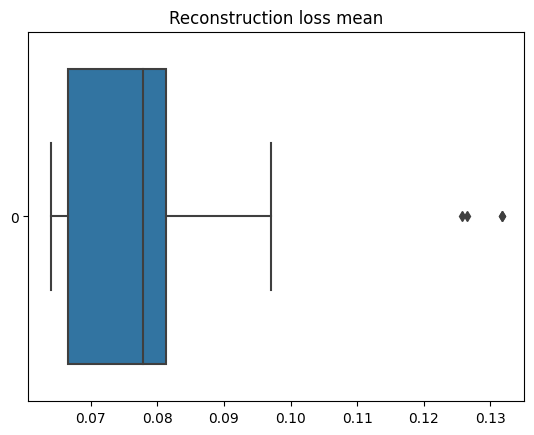

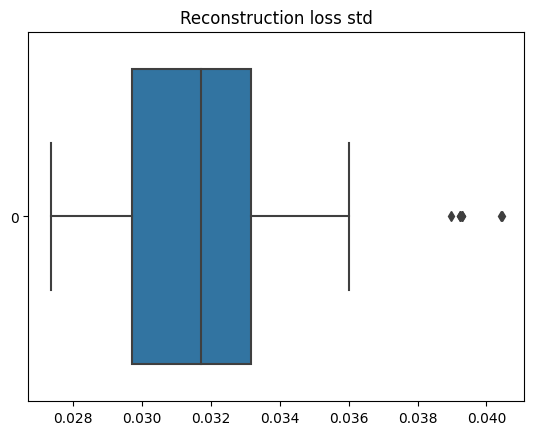

In [ ]:
reconstruction_loss = eval_results["reconstruction_loss"]

sns.boxplot(reconstruction_loss.mean(axis=0), orient = "h")
plt.title("Reconstruction loss mean")
plt.show()

sns.boxplot(reconstruction_loss.std(axis=0), orient = "h")
plt.title("Reconstruction loss std")
plt.show()

In [ ]:
print(eval_results["classification_report"])

              precision    recall  f1-score   support

       False       0.61      0.61      0.61        18
        True       0.96      0.96      0.96       165

    accuracy                           0.92       183
   macro avg       0.78      0.78      0.78       183
weighted avg       0.92      0.92      0.92       183



##Testing the ensemble


In [ ]:
def testing_ensemble(ensemble, input_data, input_labels, threshold):

    results = dict()

    # make prediction by each ensemble component
    predictions = [model.predict(input_data) for model in ensemble]

    # reconstruction loss for each component
    reconstruction_loss = np.stack(
        [tf.keras.losses.mae(pred, input_data) for pred in predictions], axis=1
    )

    results["reconstruction_loss"] = reconstruction_loss

    scaler = StandardScaler(with_mean=False)
    reconstruction_loss = scaler.fit_transform(reconstruction_loss)

    # find the median loss for each sample
    median_loss = np.median(reconstruction_loss, axis=1)

    # make predicitions
    test_outliers = np.where(median_loss > threshold, 0, 1)

    results["predictions"] = test_outliers

    print("Predictions:")
    unique, counts = np.unique(test_outliers, return_counts=True)
    print(dict(zip(["Outliers", "Non-outliers"], counts)))

    print("Real data:")
    unique1, counts1 = np.unique(input_labels, return_counts=True)
    print(dict(zip(["Outliers", "Non-outliers"], counts1)))

    results["classification_report"] = classification_report(
        input_labels.astype(bool), test_outliers.astype(bool)
    )

    # min-max scaling the reconstruction loss to calculate PR-curve
    min_ = median_loss.min()
    max_ = median_loss.max()
    scaled_loss = (median_loss - min_) / (max_ - min_)

    results["precision_recall_curve"] = precision_recall_curve(
        input_labels.astype(bool), scaled_loss
    )

    results["cohen_kappa"] = cohen_kappa_score(input_labels.astype(bool), test_outliers)

    return results



testing_results = testing_ensemble(ensemble, X_test, y_test, threshold)
print(testing_results["classification_report"])

6/6 [==============================] - 0s 15ms/step
Predictions:
{'Outliers': 23, 'Non-outliers': 161}
Real data:
{'Outliers': 24, 'Non-outliers': 160}
              precision    recall  f1-score   support

       False       0.74      0.71      0.72        24
        True       0.96      0.96      0.96       160

    accuracy                           0.93       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.93      0.93      0.93       184



##Showing results

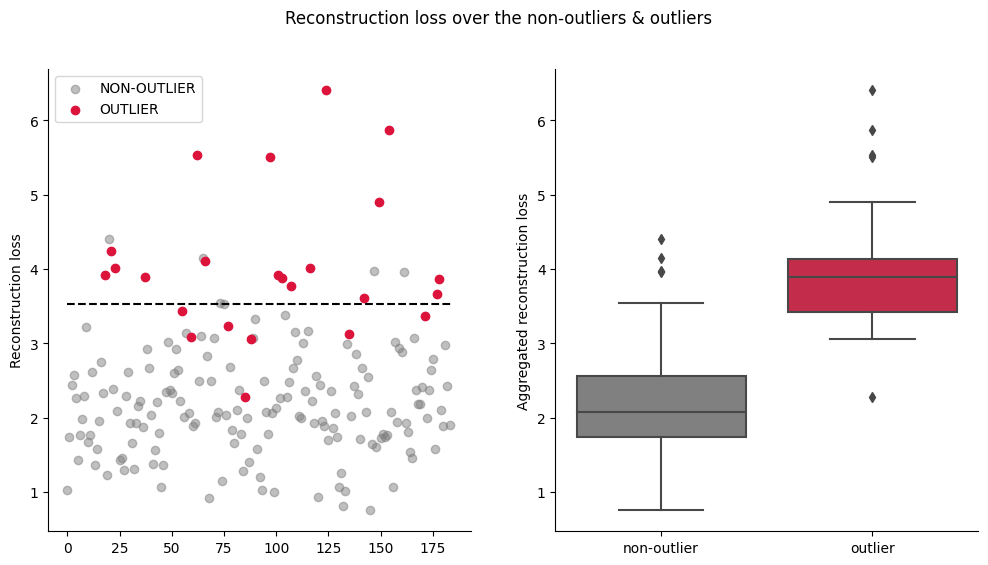

In [ ]:
# scale the reconstruction loss to account for those outliers.
scaler = StandardScaler(with_mean=False)
reconstruction_loss = scaler.fit_transform(testing_results["reconstruction_loss"], )

# aggregate loss across the ensemble components
agg_loss = np.median(reconstruction_loss, axis=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(np.where(y_test==1)[0],
            agg_loss[(y_test == 1).ravel()],
            c="grey",
            alpha=0.5)
plt.scatter(np.where(y_test == 0)[0],
            agg_loss[(y_test == 0).ravel()],
            c="crimson",
            alpha=1)
plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")
plt.ylabel("Reconstruction loss")
plt.legend(['NON-OUTLIER', "OUTLIER"])
sns.despine()

ax = plt.subplot(1, 2, 2)
plot_data = pd.DataFrame(data={"agg_loss": agg_loss, "label": np.where(y_test.ravel() == 0, "outlier", "non-outlier")})
sns.boxplot(y="agg_loss", x="label", data=plot_data, palette=["grey", "crimson"], ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Aggregated reconstruction loss")
sns.despine()

plt.suptitle("Reconstruction loss over the non-outliers & outliers")
plt.show()

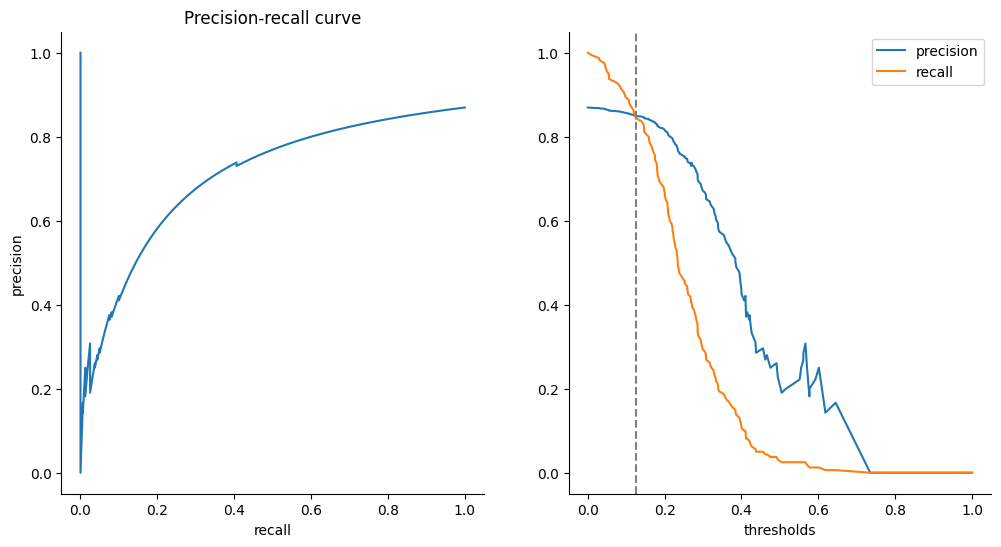

In [ ]:
prec, recall, thresholds = testing_results["precision_recall_curve"]
best_idx = np.argmin(np.abs(prec-recall))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(recall, prec)
axs[0].set_xlabel("recall")
axs[0].set_ylabel("precision")
axs[0].set_title("Precision-recall curve")
axs[1].plot(thresholds, prec[:-1], label="precision")
axs[1].plot(thresholds, recall[:-1], label="recall")
axs[1].axvline(thresholds[best_idx], 0, 1, c="grey", linestyle="--")
axs[1].set_xlabel("thresholds")
sns.despine()
plt.legend()
plt.show()

In [ ]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    auc = roc_auc_score(true_y, y_prob)
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

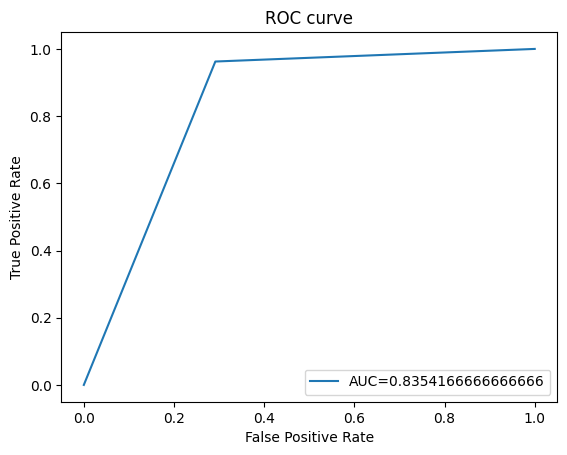

In [ ]:
plot_roc_curve(y_test.astype(bool), testing_results["predictions"].astype(bool))